<img src="CYTech.png" style="display: block; margin-left: auto; margin-right: auto; width: 30%;">

<h1 style="text-align:center; font-size:400%;"> Beenamics </h1>
<h1 style="text-align:center; font-size:200%; color:#666666"> Implementation of HoPoMo model </h1>
<br>
<h4 style="text-align:center;"> Jesse DINGLEY, Félix FROMENT, Charlie MEYER, Luca ORDONNEAU, Pierre VIRGAUX</p>

For this project we worked on the HoPoMo model. Bees are essential to pollination and their presence guarantees us better yields for our farmers. We worked on the article that first appeared in Elsevier's newspaper and then in "ECOLOGICAL MODELLING" in 2007. We have implemented the equations in Python in order to reproduce the exposed model.


***

  ## <b>1.</b> <a href="#1">Setting up</a>
  

 
 ## <b>2.</b> <a href="#2"> Model Implementation</a>
 
 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.1.</b>  <a href="#2-1">Modeling the queen’s egg laying behavior</a>

 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.2.</b>  <a href="#2-2">Modeling the immature stages</a>

 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.3.</b>  <a href="#2-3">Modeling the population of adult bees</a>

 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.4.</b>  <a href="#2-4">Modeling the influence of the environment</a>
  
 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.5.</b>  <a href="#2-5">Modeling task decisions</a>

 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.6.</b>  <a href="#2-6">Modeling the regulation of nursing</a>

 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.7.</b>  <a href="#2-7">Modeling the regulation of foraging</a>

 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.8.</b>  <a href="#2-8">Modeling the resource influx into the colony</a>

 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.9.</b>  <a href="#2-9">Regulation of food processing</a>

 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.10.</b>  <a href="#2-10">Management of nutrient stores</a>


 ## <b>3.</b> <a href="#3">Running the model</a>
 


# 1. Setting up
<div id='1'></div>

## Necessary imports

In [1]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In /home/eisti/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/eisti/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/eisti/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/eisti/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/eisti/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

## Constants

The operation of a hive is particularly complex and requires many pre-calculated values. The operation of a hive is particularly complex and requires many pre-calculated values. Many of these were given explicitly in the article, others were read from the graphs given and some were not. For some of them we determined them experimentally by observing the results graphs. We have synthesized all these variables in an appendix file so that the user can easily modify it.

In [2]:
from variables import *

## Array Initializations

We have used as you can see a lot of list to try to control infinite recursion problems. In the article the equations are given but the handling of the initial conditions remains free to be interpreted in the programming language. This method is a bit brutal but it allows us to stop the recursion problem and gives us the necessary lists to build the data frames.

In [3]:
global CELLSemptyArray, SUPcombArray, ELRArray, CELLSeggsArray, CELLSlarvaeArray, CELLSpupaeArray, CELLSbroodArray, MORTALITYadultArray, BEESadultArray, INDEXflightArray, INDEXnectaroutsideArray, INDEXpollenoutsideArray, NEEDworkersArray, RATIOworkforceArray, NEEDnursesArray, NursesArray, INDEXnursingqualityArray, FORAGERSArray, FORAGERSactiveArray, NEEDpollenArray, NEEDpollen_larvaeArray, NEEDpollen_adultArray, NEEDpollenincomeArray, NEEDpollenforagerArray, FORAGERSpollenArray, FORAGERSpollenactiveArray, NEEDnectarArray, NEEDnectar_larvaeArray, NEEDnectar_adultArray, WORKFORCEnectarArray, FORAGERSnectarArray, FORAGERSnectaractiveArray, INCOMEpollenArray, INCOMEnectarArray, INDEXpollensituationArray, NEEDprocessorsArray, PROCESSORSArray, PROCESSEDnectarArray, USAGEpollenArray, STORESpollenArray, USAGEnectarArray, USAGEhoneyArray, STORESnectarArray, STOREShoneyArray, WEIGHTcolonyArray, BEESlazyArray, TEMPArray
CELLSemptyArray = []
SUPcombArray = []
ELRArray = []
CELLSeggsArray = []
CELLSlarvaeArray = []
CELLSpupaeArray = []
CELLSbroodArray = []
MORTALITYadultArray = []
BEESadultArray = []
INDEXflightArray = []
INDEXnectaroutsideArray = []
INDEXpollenoutsideArray = []
NEEDworkersArray = []
NEEDnursesArray = []
RATIOworkforceArray = []
NursesArray = []
INDEXnursingqualityArray = []
FORAGERSArray = []
FORAGERSactiveArray = []
NEEDpollenArray = []
NEEDpollen_larvaeArray = []
NEEDpollen_adultArray = []
NEEDpollenincomeArray = []
NEEDpollenforagerArray = []
FORAGERSpollenArray = []
FORAGERSpollenactiveArray = []
NEEDnectarArray = []
NEEDnectar_larvaeArray = []
NEEDnectar_adultArray = []
WORKFORCEnectarArray = []
FORAGERSnectarArray = []
FORAGERSnectaractiveArray = []
INCOMEpollenArray = []
INCOMEnectarArray = []
INDEXpollensituationArray = []
NEEDprocessorsArray = []
PROCESSORSArray = []
PROCESSEDnectarArray = []
USAGEpollenArray = []
STORESpollenArray = []
USAGEnectarArray = []
USAGEhoneyArray = []
STORESnectarArray = []
STOREShoneyArray = []
WEIGHTcolonyArray = []
BEESlazyArray = []
TEMPArray1 = np.linspace(15, 35, 183)
TEMPArray2 = np.linspace(35, 15, 183)
TEMPArray = np.concatenate([TEMPArray1,TEMPArray2])

# 2. Model implementation
<div id='2'></div>

## 2.1.   Modeling the queen’s egg laying behavior
<div id='2-1'></div>
<div id='2'></div>

In [4]:
def season(t):
    # (1)
    return max(1-(1/(1+x1*math.exp(-2*t/x2))),1/(1+x3*math.exp(-2*(t-x4)/x5)))

In [5]:
def CELLSempty(t):
    # (2)
    global CELLSemptyArray
    if t>len(CELLSemptyArray):
        CELLSempty(t-1)
    if t==len(CELLSemptyArray):
        res = CELLShive0 - CELLSbrood(t) - STORESpollen(t) - STORESnectar(t) - STOREShoney(t)
        CELLSemptyArray = np.append(CELLSemptyArray, res)
    return CELLSemptyArray[t]

In [6]:
def SUPcomb(t):
    # (3)
    global SUPcombArray
    if t>len(SUPcombArray):
        SUPcomb(t-1)
    if t == len(SUPcombArray):
        if CELLSempty(t)/(CELLShive0 + 1) < SUPthreshold:
            res = CELLSempty(t)/((CELLShive0 + 1) * SUPthreshold)
        else:
            res = 1
        SUPcombArray = np.append(SUPcombArray, res)
    return SUPcombArray[t]

In [7]:
def ELRstoch(t):
    # (4)
    return random.uniform(-1,1)

In [8]:
def ELR(t):
    # (5)
    global ELRArray
    if t > len(ELRArray):
        ELR(t-1)
    if t == len(ELRArray):
        res = ELRbase0 * (1 + ELRstoch(t)) * (1 - season(t)) * SUPcomb(t)
        ELRArray = np.append(ELRArray, res)
    return ELRArray[t]

## 2.2. Modeling the immature stages
<div id='2-2'></div>

### 2.2.1 Eggs

In [9]:
def EGGS(i,t):
    # (6)
    if t==0:
        res = 0
    elif i == 1:
        res = ELR(t-1) * (1 - MORTALITYeggs)
    elif i in [2,3]:
        res = EGGS(i-1,t-1) * (1 - MORTALITYeggs)
    return res

In [10]:
def CELLSeggs(t):
    # (7)
    global CELLSeggsArray
    if t > len(CELLSeggsArray):
        CELLSeggs(t-1)
    if t == len(CELLSeggsArray):
        sum = 0
        for i in range(1,LIFESPANegg):
            sum += EGGS(i,t)
        CELLSeggsArray = np.append(CELLSeggsArray, sum)
    return CELLSeggsArray[t]

### 2.2.2. Larvae (unsealed)

In [11]:
def SURVIVALlarvae(i,t):
    # (9)
    return (1 - CANNIBALISMlarvae(i,t)) * (1 - MORTALITYlarvae)

In [12]:
def CANNIBALISMlarvae(i,t):
    # (10)
    if t == 0:
        res = 0
    else:
        res = CANNIBALISMhungerbase[i-1] * (1 - (INDEXpollensituation(t-1) * INDEXnursingquality(t-1)))
    return res

In [13]:
def LARVAE(i,t):
    # (11)
    if t==0:
        res = 0
    elif i == 1:
        res = EGGS(LIFESPANegg,t-1)*SURVIVALlarvae(1,t)
    elif 1 < i and i <= LIFESPANlarva:
        res = LARVAE(i-1,t-1) * SURVIVALlarvae(i,t)
    return res

In [14]:
def CELLSlarvae(t):
    # (12)
    global CELLSlarvaeArray
    if t > len(CELLSlarvaeArray):
        CELLSlarvae(t-1)
    if t == len(CELLSlarvaeArray):
        sum = 0
        for i in range(1, LIFESPANlarva):
            sum += LARVAE(i,t)
        CELLSlarvaeArray = np.append(CELLSlarvaeArray, sum)
    return CELLSlarvaeArray[t] 

In [15]:
# def CELLSlarvae13(t):
#     # (13)
#     # alternative to (12)
    
#     def product(i):
#         prdct = 1
#         for k in range(i+1):
#             if k != 0:
#                 prdct *= SURVIVALlarvae(k,t-i+k)
#         return prdct
    
#     sum = 0
#     for i in range(LIFESPANlarva+1):
#         if i != 0:
#             sum += (ELR(t-i-LIFESPANegg)*math.pow(1-MORTALITYeggs,i)*product(i))  
    
#     return sum

In [16]:
def PUPAE(i,t):
    # (14)
    if t==0:
        res =0
    elif i == 1:
        res = LARVAE(LIFESPANlarva,t-1) * (1 - MORTALITYpupae)
    elif 1 < i and i <= LIFESPANpupa:
        res = PUPAE(i-1,t-1) * (1 - MORTALITYpupae)
    return res

In [17]:
def CELLSpupae(t):
    # (15)
    global CELLSpupaeArray
    if t > len(CELLSpupaeArray):
        CELLSpupae(t-1)
    if t == len(CELLSpupaeArray):
        sum = 0
        for i in range(1,LIFESPANpupa):
            sum += PUPAE(i,t)
        CELLSpupaeArray = np.append(CELLSpupaeArray, sum)
    return CELLSpupaeArray[t] 

In [18]:
# def CELLSpupae16(t):
#     # (16)
#     # alternative to (15)
    
#     def product(i):
#         prdct = 1
#         for k in range(LIFESPANlarva+1):
#             if k != 0:
#                 prdct *= SURVIVALlarvae(k,t-i-LIFESPANlarva+k)
#         return prdct
    
#     sum = 0
#     for i in range(LIFESPANpupa+1):
#         if i != 0:
#             sum += (ELR(t-i-LIFESPANegg-LIFESPANlarva)*math.pow(1-MORTALITYeggs,LIFESPANegg)*product(i)*math.pow(1-MORTALITYpupae,i))  
    
#     return sum

In [19]:
def CELLSbrood(t):
    # (17)
    global CELLSbroodArray
    if t > len(CELLSbroodArray):
        CELLSbrood(t-1)
    if t == len(CELLSbroodArray):
        if t==0:
            res = INITCELLSbrood
        else:
            res = CELLSeggs(t) + CELLSlarvae(t) + CELLSpupae(t)
        CELLSbroodArray = np.append(CELLSbroodArray, res)
    return CELLSbroodArray[t]

## 2.3 Modeling the population of adult bees
<div id='2-3'></div>

In [20]:
def MORTALITYadult(t) :
    # (18)
    global MORTALITYadultArray
    if t > len(MORTALITYadultArray):
        MORTALITYadult(t-1)
    if t == len(MORTALITYadultArray):
        if t == 0:
            res = MORTALITYadultbase
        else:
            res = MORTALITYadultbase
            res += (MORTALITYnursing * NURSES(t - 1) / (BEESadult(t - 1) + 1))
            res += (MORTALITYprocessing * PROCESSORS(t - 1) / (BEESadult(t - 1) + 1))
            res += (MORTALITYforaging * FORAGERSactive(t - 1) / (BEESadult(t - 1) + 1))
        MORTALITYadultArray = np.append(MORTALITYadultArray, res)
    return MORTALITYadultArray[t]

In [21]:
def BEESadult(t) : 
    # (19)
    global BEESadultArray
    if t>len(BEESadultArray):
        BEESadult(t-1)
    if t==len(BEESadultArray):
        if t==0:
            res = INITBEESadult
        else:
            res = (BEESadult(t-1) + PUPAE(LIFESPANpupa, t-1))*(1 - MORTALITYadult(t))
        BEESadultArray = np.append(BEESadultArray, res)
    return BEESadultArray[t]

## 2.4 Modeling the influence of the environment
<div id='2-4'></div>

In [22]:
def INDEXrain(t) :
    # (20)
	return (1 - RAIN(t))

In [23]:
def RAIN(t) :
    # (21)
    #res = HOURSraining_during_daylight(t) / HOURSdaylight(t)
    res = 0
    return res

In [24]:
def TEMP(t):
    global TEMPArray
    return TEMPArray[t]

def INDEXtemperature(t) :
    # (22)
	if ((TEMP(t) <= 14) or (TEMP(t) > 40)) :
		res = 0
	elif (TEMP(t) <= 22) :
		res = (TEMP(t) - 14) / 8
	elif (TEMP(t) <= 32) : 
		res = 1
	else : 
		res = (40 - TEMP(t)) / 8 

	return res

In [25]:
def INDEXflight(t): 
    # (23)
    global INDEXflightArray
    if t > len(INDEXflightArray):
        INDEXflight(t-1)
    if t == len(INDEXflightArray):
        res = (INDEXrain(t) * INDEXtemperature(t))
        INDEXflightArray = np.append(INDEXflightArray, res)
    return INDEXflightArray[t]

In [26]:
def INDEXnectaroutside(t) :
    # (24)
    global INDEXnectaroutsideArray
    if t > len(INDEXnectaroutsideArray):
        INDEXnectaroutside(t-1)
    if t == len(INDEXnectaroutsideArray):
        res = min((1 - season(t)) * 1.5, 1)
        INDEXnectaroutsideArray = np.append(INDEXnectaroutsideArray, res)
    return INDEXnectaroutsideArray[t]

In [27]:
def INDEXpollenoutside(t) :
    # (25)
    global INDEXpollenoutsideArray
    if t > len(INDEXpollenoutsideArray):
        INDEXpollenoutside(t-1)
    if t == len(INDEXpollenoutsideArray):
        res = min((1 - season(t)) * 1.5, 1)
        INDEXpollenoutsideArray = np.append(INDEXpollenoutsideArray, res)
    return INDEXpollenoutsideArray[t]

## 2.5 Modeling task decisions
<div id='2-5'></div>

In [28]:
def NEEDworkers(t):
    # (26)
    global NEEDworkersArray
    if t > len(NEEDworkersArray):
        NEEDworkers(t-1)
    if t == len(NEEDworkersArray):
        res = NEEDnurses(t) + NEEDpollenforagers(t)
        NEEDworkersArray = np.append(NEEDworkersArray, res)
    return NEEDworkersArray[t]

In [29]:
def RATIOworkforce(t):
    # (27)
    global RATIOworkforceArray
    if t > len(RATIOworkforceArray):
        RATIOworkforce(t-1)
    if t == len(RATIOworkforceArray):
        res = min(BEESadult(t) * (1 - FACTORothertasks) / (NEEDworkers(t) + 1), 1)
        RATIOworkforceArray = np.append(RATIOworkforceArray, res)
    return RATIOworkforceArray[t]

## 2.6 Modeling the regulation of nursing
<div id='2-6'></div>

In [30]:
def NEEDnurses(t):
    # (28)
    global NEEDnursesArray
    if t > len(NEEDnursesArray):
        NEEDnurses(t-1)
    if t == len(NEEDnursesArray):
        res = 0
    for i in range(1, LIFESPANlarva):
        res = LARVAE(i, t) * NEEDnurses_per_larva[i]
        res += CELLSeggs(t) * NEEDnurses_per_egg + CELLSpupae(t) * NEEDnurses_per_pupa
        NEEDnursesArray = np.append(NEEDnursesArray,res)
    return NEEDnursesArray[t]

In [31]:
def NURSES(t):
    # (29)
    global NursesArray
    if t > len(NursesArray):
        NURSES(t-1)
    if t==len(NursesArray):
        res = NEEDnurses(t) * RATIOworkforce(t)
        NursesArray = np.append(NursesArray,res)
    return NursesArray[t]

In [32]:
def INDEXnursingquality(t):
    # (30)
    global INDEXnursingqualityArray
    if t>len(INDEXnursingqualityArray):
        INDEXnursingquality(t-1)
    if t==len(INDEXnursingqualityArray):
        res = NURSES(t)/(NEEDnurses(t) + 1)
        INDEXnursingqualityArray = np.append(INDEXnursingqualityArray,res)
    return INDEXnursingqualityArray[t]

## 2.7 Modeling the regulation of foraging
<div id='2-7'></div>

In [33]:
def FORAGERS(t):
    # (31) represents the available workforce for the foraging task.
    global FORAGERSArray
    if t>len(FORAGERSArray):
        FORAGERS(t-1)
    if t==len(FORAGERSArray):
        res = FORAGERSpollen(t)+FORAGERSnectaractive(t)
        FORAGERSArray = np.append(FORAGERSArray,res)
    return FORAGERSArray[t]

In [34]:
def FORAGERSactive(t):
    # (32) represents the actual number of foragers that fly out
    global FORAGERSactiveArray
    if t>len(FORAGERSactiveArray):
        FORAGERSactive(t-1)
    if t==len(FORAGERSactiveArray):
        res = FORAGERSpollenactive(t)+FORAGERSnectaractive(t)
        FORAGERSactiveArray = np.append(FORAGERSactiveArray,res)
    return FORAGERSactiveArray[t]

### 2.7.1 Recruitment of pollen foragers

In [35]:
def NEEDpollen(t):
    # (33) calculate the colony’s pollen demand
    global NEEDpollenArray
    if t>len(NEEDpollenArray):
        NEEDpollen(t-1)
    if t==len(NEEDpollenArray):
        res = NEEDpollen_larvae(t)+NEEDpollen_adult(t)
        NEEDpollenArray = np.append(NEEDpollenArray,res)
    return NEEDpollenArray[t]

In [36]:
def NEEDpollen_larvae(t):
    # (34) represents the pollen demand of larvae of all ages
    global NEEDpollen_larvaeArray
    if t>len(NEEDpollen_larvaeArray):
        NEEDpollen_larvae(t-1)
    if t==len(NEEDpollen_larvaeArray):
        result = 0
        for i in range(1,LIFESPANlarva):
            result+= (POLLENNEEDlarva[i-1]*(LARVAE(i,t)))
        NEEDpollen_larvaeArray = np.append(NEEDpollen_larvaeArray,result)
    return NEEDpollen_larvaeArray[t]

In [37]:
def NEEDpollen_adult(t):
    # (35) represents the adult’s pollen demand
    global NEEDpollen_adultArray
    if t>len(NEEDpollen_adultArray):
        NEEDpollen_adult(t-1)
    if t==len(NEEDpollen_adultArray): 
        result = BEESadult(t) * POLLENNEEDadult + NURSES(t) * POLLENNEEDnurse
        NEEDpollen_adultArray = np.append(NEEDpollen_adultArray,result)
    return NEEDpollen_adultArray[t]

In [38]:
def NEEDpollenincome(t):
    # (36) represents the daily need for pollen income
    global NEEDpollenincomeArray
    if t>len(NEEDpollenincomeArray):
        NEEDpollenincome(t-1)
    if t==len(NEEDpollenincomeArray):
        S = 0
        if t==0:
            S = 0
        elif t==1:
            S += NEEDpollen(t)
            S += NEEDpollen(t-1)
        else:
            S += NEEDpollen(t)
            S += NEEDpollen(t-1)
            S += NEEDpollen(t-2)
        tmp = S/3 * FACTORpollenstorage - STORESpollen(t)
        result = max(0,tmp)
        NEEDpollenincomeArray = np.append(NEEDpollenincomeArray,result)
    return NEEDpollenincomeArray[t]

In [39]:
def NEEDpollenforagers(t):
    # (37) models the number of pollen foragers needed according to the current need for additional pollen.
    global NEEDpollenforagerArray
    if t>len(NEEDpollenforagerArray):
        NEEDpollenforagers(t-1)
    if t==len(NEEDpollenforagerArray):
        if t==0:
            result = NEEDpollenincome(0) / (LOADpollenforager * TURNSpollenforager * FACTORforagingsuccess)
        else:
            result = NEEDpollenincome(t-1) / (LOADpollenforager * TURNSpollenforager * FACTORforagingsuccess)
        NEEDpollenforagerArray = np.append(NEEDpollenforagerArray,result)
    return NEEDpollenforagerArray[t]

In [40]:
def FORAGERSpollen(t):
    # (38) models the potential number of pollen foragers each day
    global FORAGERSpollenArray
    if t>len(FORAGERSpollenArray):
        FORAGERSpollen(t-1)
    if t==len(FORAGERSpollenArray):
        max1 = NEEDpollenforagers(t) * RATIOworkforce(t)
        max2 = (BEESadult(t)-NURSES(t))*FACTORminpollenforagers
        min1 = max(max1,max2)
        min2 = BEESadult(t) * FACTORforagingmax
        result = min(min1,min2)
        FORAGERSpollenArray = np.append(FORAGERSpollenArray,result)
    return FORAGERSpollenArray[t]

In [41]:
def FORAGERSpollenactive(t):
    # (39) models the number of foragers that actually leave the hive for foraging flights
    global FORAGERSpollenactiveArray
    if t>len(FORAGERSpollenactiveArray):
        FORAGERSpollenactive(t-1)
    if t==len(FORAGERSpollenactiveArray):
        result = FORAGERSpollen(t) * INDEXflight(t) * INDEXpollenoutside(t)
        FORAGERSpollenactiveArray = np.append(FORAGERSpollenactiveArray,result)
    return FORAGERSpollenactiveArray[t]




### 2.7.2 Recruitment of nectar foragers

In [42]:
def NEEDnectar(t):
    # (40) model the demand for nectar
    global NEEDnectarArray
    if t>len(NEEDnectarArray):
        NEEDnectar(t-1)
    if t==len(NEEDnectarArray):
        result = NEEDnectar_larvae(t) + NEEDnectar_adult(t)
        NEEDnectarArray = np.append(NEEDnectarArray,result)
    return NEEDnectarArray[t]

In [43]:
def NEEDnectar_larvae(t):
    # (41) model the demand for larvae nectar
    global NEEDnectar_larvaeArray
    if t>len(NEEDnectar_larvaeArray):
        NEEDnectar_larvae(t-1)
    if t==len(NEEDnectar_larvaeArray):
        result = 0
        for i in range(1,LIFESPANlarva):
            result += NECTARNEEDlarva[i-1] * LARVAE(i,t)
        NEEDnectar_larvaeArray = np.append(NEEDnectar_larvaeArray,result)
    return NEEDnectar_larvaeArray[t]

In [44]:
def NEEDnectar_adult(t):
    # (42)model the demand for adult nectar
    global NEEDnectar_adultArray
    if t>len(NEEDnectar_adultArray):
        NEEDnectar_adult(t-1)
    if t==len(NEEDnectar_adultArray):
        result = BEESadult(t) * NECTARNEEDadult + NURSES(t) * NECTARNEEDnurse + FORAGERSactive(t) * NECTARNEEDactiveforager
        NEEDnectar_adultArray = np.append(NEEDnectar_adultArray,result)
    return NEEDnectar_adultArray[t]

In [45]:
def WORKFORCEnectar(t):
    # (43) calculates the number of adult bees that are not involved in other tasks and thus are still available for a task associated with nectar collection
    global WORKFORCEnectarArray
    if t>len(WORKFORCEnectarArray):
        WORKFORCEnectar(t-1)
    if t==len(WORKFORCEnectarArray):
        result = 0
        if (RATIOworkforce(t) == 1):
            result = (BEESadult(t) * (1 - FACTORothertasks)) - NURSES(t) - FORAGERSpollen(t)
        WORKFORCEnectarArray = np.append(WORKFORCEnectarArray,result)
    return WORKFORCEnectarArray[t]

In [46]:
def FORAGERSnectar(t):
    # (44) models the number of potential nectar foragers
    global FORAGERSnectarArray
    if t>len(FORAGERSnectarArray):
        FORAGERSnectar(t-1)
    if t==len(FORAGERSnectarArray):
        min1 = (BEESadult(t) * FACTORforagingmax) - FORAGERSpollen(t)
        min2 = WORKFORCEnectar(t) - PROCESSORS(t)
        result = min(min1,min2)
        FORAGERSnectarArray = np.append(FORAGERSnectarArray,result)
    return FORAGERSnectarArray[t]

In [47]:
def FORAGERSnectaractive(t): 
    # (45) models the number of nectar foragers that actually leave the hive for foraging flights
    global FORAGERSnectaractiveArray
    if t>len(FORAGERSnectaractiveArray):
        FORAGERSnectaractive(t-1)
    if t==len(FORAGERSnectaractiveArray):
        result = FORAGERSnectar(t) * INDEXflight(t) * INDEXnectaroutside(t)
        FORAGERSnectaractiveArray = np.append(FORAGERSnectaractiveArray,result)
    return FORAGERSnectaractiveArray[t]

## 2.8 Modeling the resource influx into the colony
<div id='2-8'></div>

In [48]:
def INCOMEpollen(t):
    # (46) project the daily influx of pollen
    global INCOMEpollenArray
    if t>len(INCOMEpollenArray):
        INCOMEpollen(t-1)
    if t==len(INCOMEpollenArray):
        result = FORAGERSpollenactive(t) * LOADpollenforager * TURNSpollenforager * FACTORforagingstoch(t) * FACTORforagingsuccess
        INCOMEpollenArray = np.append(INCOMEpollenArray,result)
    return INCOMEpollenArray[t]

In [49]:
def FACTORforagingstoch(t):
    # (47) used to vary the daily foraging success symmetrically around 1
    result = random.uniform(0.75, 1.25)
    return(result)

In [50]:
def INDEXpollensituation(t):
    # (48) describes the level of the pollen stores in relation to the demand situation of the colony
    global INDEXpollensituationArray
    if t>len(INDEXpollensituationArray):
        INDEXpollensituation(t-1)
    if t==len(INDEXpollensituationArray):
        min1 = STORESpollen(t) / (NEEDpollen(t) * FACTORpollenstorage + 1)
        result = min(1,min1)
        INDEXpollensituationArray = np.append(INDEXpollensituationArray,result)
    return INDEXpollensituationArray[t]

In [51]:
def INCOMEnectar(t):
    # (49) project the daily influx of nectar
    global INCOMEnectarArray
    if t>len(INCOMEnectarArray):
        INCOMEnectar(t-1)
    if t==len(INCOMEnectarArray):
        min1 = FORAGERSnectaractive(t) * LOADnectarforager * TURNSnectarforager * FACTORforagingstoch(t) * FACTORforagingsuccess
        min2 = CELLSempty(t - 1)
        result = min(min1,min2)
        INCOMEnectarArray = np.append(INCOMEnectarArray,result)
    return INCOMEnectarArray[t]

## 2.9 Regulation of food processing
<div id='2-9'></div>

The number of nectar processing bees and foraging bees should normally be in balance. However, nectar processing has priority over nectar treatment so that it is always available for foraging. 

In [52]:
def NEEDprocessors(t):
    #(50)
    global NEEDprocessorsArray
    if t>len(NEEDprocessorsArray):
        NEEDprocessors(t-1)
    if t==len(NEEDprocessorsArray):
        if t==0:
            result = STORESnectar(0)*ProcessorsPerCell
        else:
            result = STORESnectar(t-1)*ProcessorsPerCell
        NEEDprocessorsArray = np.append(NEEDprocessorsArray,result)
    return NEEDprocessorsArray[t]

In [53]:
def PROCESSORS(t):
    #(51)
    global PROCESSORSArray
    if t>len(PROCESSORSArray):
        PROCESSORS(t-1)
    if t==len(PROCESSORSArray):
        
        result = min(NEEDprocessors(t), WORKFORCEnectar(t))
        PROCESSORSArray = np.append(PROCESSORSArray,result)
    return PROCESSORSArray[t]

In [54]:
def PROCESSEDnectar(t):
    #(52)
    global PROCESSEDnectarArray
    if t>len(PROCESSEDnectarArray):
        PROCESSEDnectar(t-1)
    if t==len(PROCESSEDnectarArray):
        if t==0:
            result = min(STORESnectar(0)-USAGEnectar(t), PROCESSORS(t)/ProcessorsPerCell)
        else:
            result = min(STORESnectar(t-1)-USAGEnectar(t), PROCESSORS(t)/ProcessorsPerCell)
        PROCESSEDnectarArray = np.append(PROCESSEDnectarArray,result)
    return PROCESSEDnectarArray[t]

The system proposed by the model is simplified compared to what exists in nature. Here we use only the nectare stored one day before.

## 2.10 Management of nutrient stores
<div id='2-10'></div>

The daily usage (consumption) of pollen is highly dependent on the amount of pollen stored. When it is too low the bees have the possibility to reduce their consumption and feed less their brood.

In [55]:
def USAGEpollen(t):
    #(53)
    global USAGEpollenArray
    if t>len(USAGEpollenArray):
        USAGEpollen(t-1)
    if t==len(USAGEpollenArray):
        if t==0:
            result = min(STORESpollen(t), NEEDpollen(0)*(1-(FACTORpollensavingmax*(1-INDEXpollensituation(0)))))
        else:
            result = min(STORESpollen(t-1), NEEDpollen(t-1)*(1-(FACTORpollensavingmax*(1-INDEXpollensituation(t-1)))))
        USAGEpollenArray = np.append(USAGEpollenArray,result)
    return USAGEpollenArray[t]

The daily amount of stored pollen is expressed as bellow.

In [56]:
def STORESpollen(t):
    #(54)
    global STORESpollenArray
    if t>len(STORESpollenArray):
        STORESpollen(t-1)
    if t==len(STORESpollenArray):
        if t==0:
            result = INITpollen
        else:
            result = STORESpollen(t-1) + INCOMEpollen(t) - USAGEpollen(t)
        STORESpollenArray = np.append(STORESpollenArray,result)
    return STORESpollenArray[t]

The use of pollen and nectar also depends on the stock situation. The bees first favour the consumption of fresh nectar and then pick up the stored nectar. In winter the bees are more likely to draw from stored nectar.

In [57]:
def USAGEnectar(t):
    #(55)
    global USAGEnectarArray
    if t>len(USAGEnectarArray):
        USAGEnectar(t-1)
    if t==len(USAGEnectarArray):
        if t==0:
            result = min(STORESnectar(0), NEEDnectar(0))
        else:
            result = min(STORESnectar(t-1), NEEDnectar(t))
        USAGEnectarArray = np.append(USAGEnectarArray,result)
    return USAGEnectarArray[t]

In [58]:
def USAGEhoney(t):
    #(56)
    global USAGEhoneyArray
    if t>len(USAGEhoneyArray):
        USAGEhoney(t-1)
    if t==len(USAGEhoneyArray):
        if t==0:
            result = min(STOREShoney(0), (NEEDnectar(t)-USAGEnectar(t))*RATIOnectar_to_honey)
        else:
            result = min(STOREShoney(t-1), (NEEDnectar(t)-USAGEnectar(t))*RATIOnectar_to_honey)
        USAGEhoneyArray = np.append(USAGEhoneyArray,result)
    return USAGEhoneyArray[t]

From the equations 49, 52, 55, 56 we can deduce the 2 following functions.

In [59]:
def STORESnectar(t):
    #(57)
    global STORESnectarArray
    if t>len(STORESnectarArray):
        STORESnectar(t-1)
    if t==len(STORESnectarArray):
        if t==0:
            result = INITnectar
        else:
            result = STORESnectar(t-1)+INCOMEnectar(t) - USAGEnectar(t)-PROCESSEDnectar(t)
        STORESnectarArray = np.append(STORESnectarArray,result)
    return STORESnectarArray[t]

In [60]:
def STOREShoney(t):
    #(58)
    global STOREShoneyArray
    if t>len(STOREShoneyArray):
        STOREShoneyArray(t-1)
    if t==len(STOREShoneyArray):
        if t==0:
            result = INIThoney
        else:
            result = STOREShoney(t-1)-USAGEhoney(t)+(PROCESSEDnectar(t)*RATIOnectar_to_honey)
        STOREShoneyArray = np.append(STOREShoneyArray,result)
    return STOREShoneyArray[t]

The weight of the hive is given in kg. To obtain it, the weight of each of the elements of the hive must be added together. 

In [61]:
def WEIGHTcolony(t):
    #(59)
    global WEIGHTcolonyArray
    if t>len(WEIGHTcolonyArray):
        WEIGHTcolony(t-1)
    if t==len(WEIGHTcolonyArray):
        if t==0:
            result = INITWEIGHTcolony
        else:
            res = 0
            for i in range(1, LIFESPANlarva):
                res = res + (w_larva[i-1]*LARVAE(i,t))

            result = (1/1000)*(w_hivebase+w_cellsbase*CELLShive0+w_pollen*STORESpollen(t)
                    +w_honey*STOREShoney(t)+w_egg*CELLSeggs(t)
                    +w_pupa*CELLSpupae(t)
                    +res
                    +w_adult*BEESadult(t))
        WEIGHTcolonyArray = np.append(WEIGHTcolonyArray,result)
    return WEIGHTcolonyArray[t]

A number of bees are sometimes not necessary because of the weather or the fact that the cells of the hive are already filled.

In [62]:
def BEESlazy(t):
    #(60)
    global BEESlazyArray
    if t>len(BEESlazyArray):
        BEESlazy(t-1)
    if t==len(BEESlazyArray):
        result = (BEESadult(t)*(1-FACTORothertasks))-FORAGERSactive(t)-NURSES(t)-PROCESSORS(t)
        BEESlazyArray = np.append(BEESlazyArray,result)
    return BEESlazyArray[t]

## Swarming extension

In [63]:
#def FACTORqueen(t):
  # (61)
#    if ((swd - 30) <= t and t < (swd -3)):
#        res = 1.2
#    elif ((swd - 3) <= t and t < (swd + 14)):
#        res = 0
#    else:
#        res = 1
#    return res

In [64]:
#def ELRbase(t):
  # (62)
#    if (t<swd):
#        res = 2000
#    else:
#        res = 1200
#    return res

In [65]:
#def BEESswarm(t):
  # (63)
#    if (t == swd):
#        res = BEESadult(t-1) * 0.6
#    else:
#        res = 0
#    return res

In [66]:
#def TURNSnectarforager(t):
    # (64)
#    return 15 + 7 * ((CELLSempty(t-1))/(CELLShive(t)+1))

In [67]:
#def LOSShoney_swarm(t):
    # (65)
#    if t == swd:
#        return min(STOREShoney(t-1),BEESswarm(t)*LOADnectarforager)
#    else:
#        return 0

In [68]:
#def USAGEhoney(t):
    # (56a)
#    return min((STOREShoney(t-1),((NEEDnectar(t)-USAGEnectar(t))*RATIOnectar_to_honey)+LOSShoney_swarm(t))

In [69]:
#def CELLShive(t):
    # (67)
#    if t <= swd:
#        return CELLShive0
#    elif swd < t and t <= (swd + 7):
#        return CELLShive(t-1)+(2000/7)
#    elif (swd + 7) < t and t <= (swd + 97):
#        return CELLShive(t-1)+(8000/90)
#    elif t > (swd + 97):
#        return CELLShive(t-1)

# 3. Running the model
<div id='3'></div>

In [70]:
def Main(daysEnd):
    t = np.arange(daysEnd+1)
    for i in range(len(t)):
        CELLSeggs(t[i])
        CELLSlarvae(t[i])
        CELLSpupae(t[i])
        CELLSbrood(t[i])
        BEESadult(t[i])
        STORESpollen(t[i])
        STORESnectar(t[i])
        STOREShoney(t[i])
        WEIGHTcolony(t[i])
    dFResult = pd.DataFrame({'STORESpollen' : STORESpollenArray, 'STOREShoney' : STOREShoneyArray, 'STORESnectar' : STORESnectarArray, 'BroodCells' : CELLSbroodArray,'BEESadult' : BEESadultArray,'WEIGHTcolony' : WEIGHTcolonyArray})
    return dFResult

Text(0.5, 1.0, 'Season Coeff')

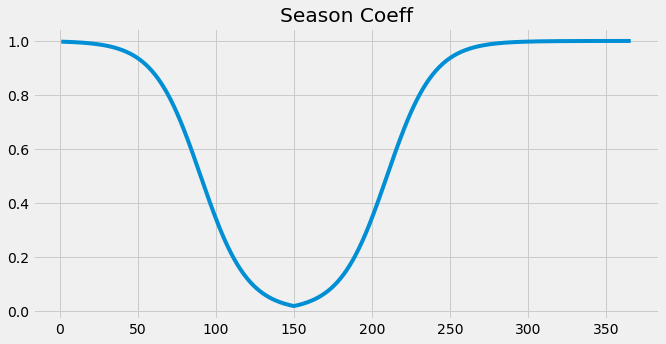

In [71]:
import matplotlib.pyplot as plt
import numpy as np

graph = []

for i in range(366):
    graph.append(season(i))

plt.figure(figsize=(10,5))
plt.plot(np.linspace(1,366, 366), graph)
plt.title("Season Coeff")

In [72]:
res = Main(365)
res.to_csv("test.csv")

In [73]:
res.describe()

,STORESpollen,STOREShoney,STORESnectar,BroodCells,BEESadult,WEIGHTcolony
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,275.851965,13042.159760,1151.624188,5538.453565,19555.413417,32.324825
std,326.634932,13150.339781,1466.572036,6642.888775,9893.310000,6.335016
min,0.000000,0.000000,0.000000,0.000000,6383.003661,24.299349
25%,2.868481,0.000000,11.429266,65.355545,10884.716253,25.882362
50%,89.926668,14237.329967,291.181834,1320.201490,17257.354387,33.671260
75%,606.247975,18728.511321,2244.550958,11737.397331,28651.261734,36.189267
max,984.943219,50000.000000,5507.831899,20279.486612,36970.892569,50.000000


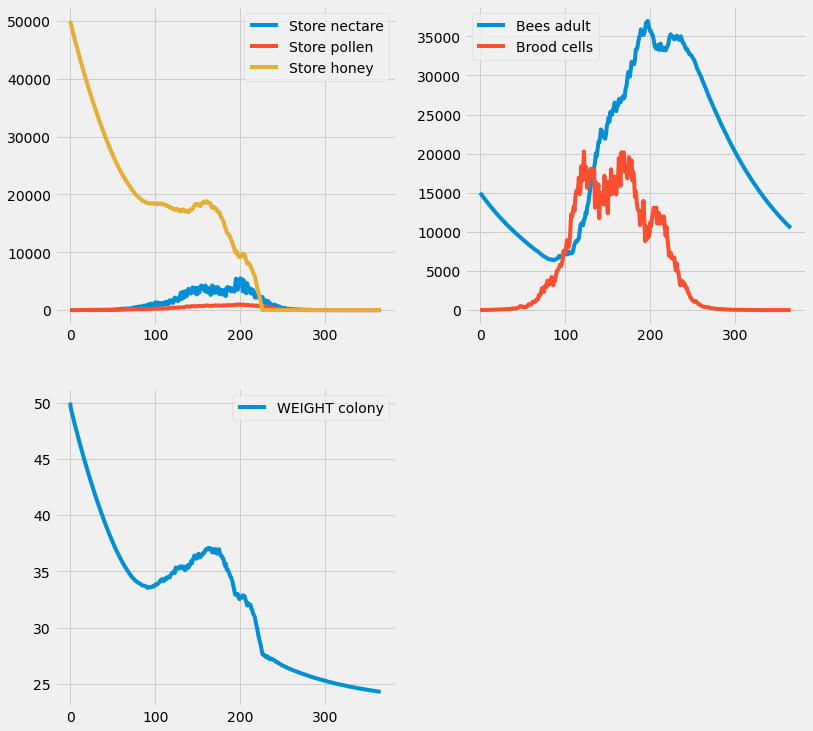

In [74]:
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)

res['STORESnectar'].plot(label = "Store nectare")
res['STORESpollen'].plot(label = "Store pollen")
res['STOREShoney'].plot(label = "Store honey")
plt.legend()

plt.subplot(2,2,2)

res['BEESadult'].plot(label = "Bees adult")
res['BroodCells'].plot(label = "Brood cells")

plt.legend()

plt.subplot(2,2,3)
res['WEIGHTcolony'].plot(label = "WEIGHT colony")
plt.legend()

Text(0, 0.5, 'usage honey [cells / days]')

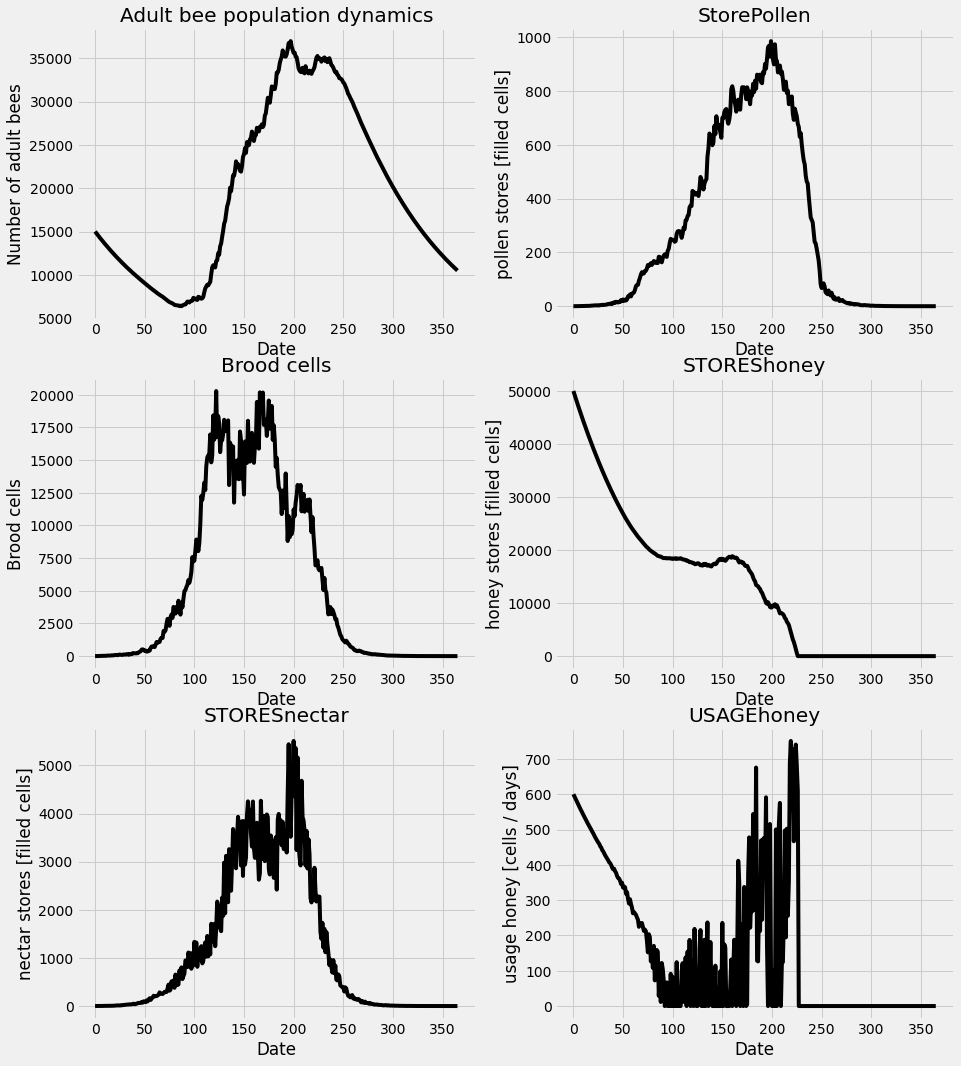

In [75]:
plt.figure(figsize=(14,17))

t = np.arange(366)

plt.subplot(3,2,1)
#plt.legend(loc = 'upper right')
plt.plot(t, BEESadultArray,color = 'black')
plt.title('Adult bee population dynamics')
plt.xlabel('Date')
plt.ylabel('Number of adult bees')


plt.subplot(3,2,2)
plt.plot(t, STORESpollenArray,color = 'black')
plt.title('StorePollen')
plt.xlabel('Date')
plt.ylabel('pollen stores [filled cells]')

plt.subplot(3,2,3)
plt.plot(t,CELLSbroodArray,color  = 'black')
plt.title('Brood cells')
plt.xlabel('Date')
plt.ylabel('Brood cells')

plt.subplot(3,2,4)
plt.plot(t, STOREShoneyArray,color = 'black')
plt.title('STOREShoney')
plt.xlabel('Date')
plt.ylabel('honey stores [filled cells]')

plt.subplot(3,2,5)
plt.plot(t, STORESnectarArray,color = 'black')
plt.title('STORESnectar')
plt.xlabel('Date')
plt.ylabel('nectar stores [filled cells]')

plt.subplot(3,2,6)
plt.plot(t, USAGEhoneyArray,color = 'black')
plt.title('USAGEhoney')
plt.xlabel('Date')
plt.ylabel('usage honey [cells / days]')